# CTR bootstrap

Цель: провести A/B тест по метрике CTR (click-through rate) для двух рекламных объявлений с целью определения различий в их эффективности.

## EDA

In [69]:
import pandas as pd
import datetime as dt

import numpy as np
import timeit
# from statsmodels.stats.gof import chisquare_effectsize
# from statsmodels.stats.power import GofChisquarePower
# from statsmodels.stats.proportion import proportions_chisquare
from sklearn.utils import resample

from numba import njit

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### Данные по кликам на рекламные объявления

In [45]:
impressions = pd.read_csv('/content/drive/MyDrive/CTR_data/train.csv')
impressions['impression_time'] = pd.to_datetime(impressions['impression_time'])
impressions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237609 entries, 0 to 237608
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   impression_id    237609 non-null  object        
 1   impression_time  237609 non-null  datetime64[ns]
 2   user_id          237609 non-null  int64         
 3   app_code         237609 non-null  int64         
 4   os_version       237609 non-null  object        
 5   is_4G            237609 non-null  int64         
 6   is_click         237609 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 12.7+ MB


In [46]:
impressions.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0


In [47]:
impressions.nunique()

impression_id      237609
impression_time     36461
user_id             74723
app_code              490
os_version              3
is_4G                   2
is_click                2
dtype: int64

impression_id - id показа рекламы  
impression_time - время показа рекламы  
user_id - id пользователя  
is_click - нажатие на рекламу

In [48]:
print(f'Временной период: {impressions.impression_time.min()} - {impressions.impression_time.max()}')

Временной период: 2018-11-15 00:00:00 - 2018-12-13 07:43:00


## Предварительная оценка CTR

Заранее известно, что распределение числа кликов является Биномиальным, а распределение числа просмотров - логнормальное. Было выяснено, что для получения состоятельно результата, необходимо собрать данные, которые мы можем получить примерно за месяц. Проверять гипотезу изначально предлагается с использованием теста Хи-квадрат: имеем две категориальные переменные (метка группы и метка клика), все наблюдения независимы, поскольку каждый пользователь действует независимо от других (метка группы назначается пользователю случайно), просмотры и клики каждого пользователя учитываются только один раз. То есть все допущения данного теста выполняются. Предположим, реклама висит уже неделю. За это время были собраны данные по кликам для двух групп пользователей, но для проведения теста с заданной желаемой мощьностью, чтобы он улавливал необходимый размер эффекта, их пока не достаточно. Однако требуется провести тест уже сейчас. Выход - прибегнуть к процедуре бутстрапа. Классический бутстрап запускать довольно дорого по времени и по памяти из-за имеющегося объема данных (да и требует он наличия конечной выборки и знания числа наблюдений в ней), а если используются параллельные вычисления, то необходимо также контролировать сумму весов наблюдений (= n), генерируемых из биномиального распределения, для каждой бутстраповской выборки. Пуассоновская аппроксимация дает свободу от: 1) знания n, которое требуется для генерации весов из биномиального распределения; 2) проблем, которые создаются параллельными вычислениями, для классического бутстрапа.

In [49]:
start_date = dt.datetime(2018, 11, 15)
end_date = dt.datetime(2018, 11, 21)
dt_mask = (impressions['impression_time'] > start_date) & (impressions['impression_time'] < end_date)  # недельные данные

In [50]:
user_level_ctr = impressions.groupby('user_id', as_index=False).agg({'is_click': ['sum', 'count']}).droplevel(0, axis=1)
user_level_ctr.columns = ['user_id', 'clicks', 'views']
user_level_ctr.head()

,user_id,clicks,views
0,0,0,1
1,2,0,4
2,3,0,1
3,5,0,2
4,6,0,1


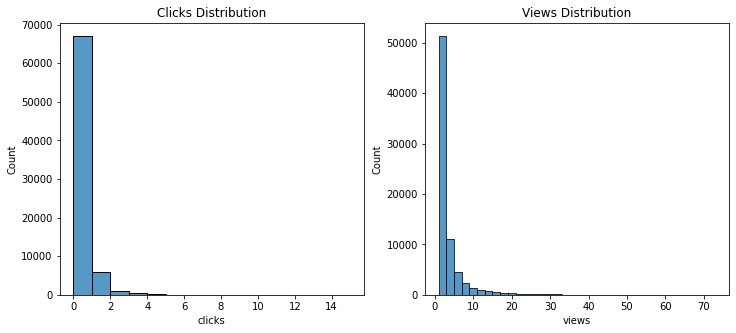

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].set_title('Clicks Distribution')
sns.histplot(ax=axes[0], data=user_level_ctr['clicks'], binwidth=1)
axes[1].set_title('Views Distribution')
sns.histplot(ax=axes[1], data=user_level_ctr['views'], binwidth=2)
plt.show()

In [52]:
pd.options.mode.chained_assignment = None

In [85]:
# синтетически делим пользователей на 2 группы, предполагая, что это делается в самом процессе проведения теста
control_group_data = user_level_ctr.sample(n=len(user_level_ctr) // 2, random_state=33)
treatment_group_data = user_level_ctr[~user_level_ctr.user_id.isin(control_group_data.user_id.values)]
control_group_data['group_label'] = ['control'] * control_group_data.shape[0]
treatment_group_data['group_label'] = ['treatment'] * treatment_group_data.shape[0]
print(control_group_data.shape[0], treatment_group_data.shape[0])

37361 37362


In [86]:
user_level_ctr = pd.concat([control_group_data, treatment_group_data]).sort_values('user_id')
user_level_ctr.head()

,user_id,clicks,views,group_label
0,0,0,1,control
1,2,0,4,treatment
2,3,0,1,control
3,5,0,2,control
4,6,0,1,control


In [87]:
contingency_table = user_level_ctr.copy()
contingency_table['views'] = contingency_table['views'] - contingency_table['clicks']
contingency_table.rename(columns={'clicks': 'click', 'views': 'no_click'}, inplace=True)
contingency_table = pd.melt(contingency_table, id_vars=['user_id', 'group_label'], value_vars=['click', 'no_click'], var_name='is_click', value_name='count')
contingency_table = contingency_table.pivot_table(index='is_click', columns='group_label', values='count', aggfunc='sum')
contingency_table.columns.name, contingency_table.index.name = '', ''
contingency_table

,control,treatment
,,
click,5289,5573
no_click,111981,114766


Дисбаланса классов нет.

In [88]:
global_ctr_control = control_group_data['clicks'].sum() / control_group_data['views'].sum()
global_ctr_treatment = treatment_group_data['clicks'].sum() / treatment_group_data['views'].sum()

In [89]:
print('Control group global CTR: {:.2%}'.format(global_ctr_control))
print('Treatment group global CTR: {:.2%}'.format(global_ctr_treatment))

Control group global CTR: 4.51%
Treatment group global CTR: 4.63%


## Сравнение быстродействия классического и Пуассоновоского бутстрапа

In [90]:
def poisson_bootstrap(B):
    # работает при n >= 100, так как сумма элементов вектора не фиксирована и не равна n (доп. источник вариации)
    sampled = np.random.poisson(1, B)

def multinomial_bootstrap(n):
    # сумма элементов вектора фиксирована и равна n
    sampled = np.random.multinomial(n, [1. / n] * n)

In [91]:
n = len(user_level_ctr)
B = 1000
print(n, B)

74723 1000


In [92]:
# средняя сумма k в одной подвыборке для классического бутстрапа совпадает с n
multinomial_samples = np.array([np.random.multinomial(n, [1. / n] * n) for i in range(B)])
np.mean([np.sum(multinomial_samples[i]) for i in range(B)])

74723.0

In [93]:
# средняя сумма k в одной подвыборке для Пуассоновского бутстрапа аппроксимирует n
poisson_samples = np.array([np.random.poisson(1, B) for i in range(n)]).T
np.mean([np.sum(poisson_samples[i]) for i in range(B)])

74737.712

При больших n этим можно пренебречь.

In [94]:
%%timeit
# генерируем вектор длины B из пуассоновского распределения n раз (независимо один раз для каждого наблюдения)
list(map(poisson_bootstrap, [B for i in range(n)]))

4.76 s ± 423 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [95]:
%%timeit
# генерируем вектор длины n из мультиномиального распределения B раз
list(map(multinomial_bootstrap, [n for i in range(B)]))

10.8 s ± 590 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


\* Ускоренный станадартный бутстрап

In [96]:
fast_multinomial_bootstrap = njit(multinomial_bootstrap)

In [97]:
%%timeit
list(map(fast_multinomial_bootstrap, [n for i in range(B)]))

9.51 s ± 444 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Вывод: Пуассоновский бутстрап работает быстрее. Используем его.

## Сравнение на примере оценки эффективности двух рекламных объявлений

Если в итоге доверительный интервал для разности CTR пересечет 0, то разность не значима статистически.

In [98]:
alpha = 0.05

##### Классический бутстрап

Необходимо знать n, то есть иметь конечную выборку

In [120]:
def multinomial_boot(main_sample, B):
    result = []
    for rep in range(B):
        control_sample = resample(main_sample.loc[main_sample['group_label'] == 'control'])
        treatment_sample = resample(main_sample.loc[main_sample['group_label'] == 'treatment'])
        ctr_control = control_sample['clicks'].sum() / control_sample['views'].sum()
        ctr_treatment = treatment_sample['clicks'].sum() / treatment_sample['views'].sum()
        result.append(ctr_treatment - ctr_control)
    result = pd.Series(result)
    return result

In [121]:
%%timeit
multinomial_boot(user_level_ctr, B)

20.9 s ± 137 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [110]:
classic_boot_res = multinomial_boot(user_level_ctr, B)

In [111]:
print('Исходно: {:.7f}'.format(global_ctr_treatment - global_ctr_control))
print('Бутстрап: {:.7f}'.format(classic_boot_res.mean()))
quantile_l = np.quantile(classic_boot_res, alpha / 2)
quantile_r = np.quantile(classic_boot_res, 1 - alpha / 2)
print('Доверительный инетрвал: ({:.7f}; {:.7f})'.format(quantile_l, quantile_r))
print('Стандартная ошибка: {:.7f}'.format(classic_boot_res.std()))
bias = classic_boot_res.mean() - (global_ctr_treatment - global_ctr_control)
print(f'Смещение: {bias}')

Исходно: 0.0012098
Бутстрап: 0.0012178
Доверительный инетрвал: (-0.0008913; 0.0033235)
Стандартная ошибка: 0.0011000
Смещение: 8.009872914361681e-06


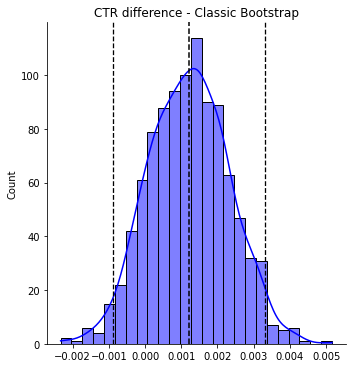

In [113]:
sns.displot(classic_boot_res, kde=True, color='blue')
plt.title('CTR difference - Classic Bootstrap')
plt.axvline(classic_boot_res.mean(), ls='--', lw=1.5, c='black')
plt.axvline(quantile_l, ls='--', lw=1.3, c='black')
plt.axvline(quantile_r, ls='--', lw=1.3, c='black')
plt.show()

##### Пуассоновский бутстрап

Не зависит от n, данные можно обрабатывать потоково и остановить процедуру в любой момент

In [124]:
def poisson_boot(data_source, B):
    control_result = np.array([[0, 0]] * B)  # значения будут обновляться при поступлении нового наблюдения
    treatment_result = np.array([[0, 0]] * B)
    for idx, row in data_source.iterrows():
        weights = np.random.poisson(1, B)
        if row['group_label'] == 'control':
            control_result[:, 0] += row['clicks'] * weights  # numerator
            control_result[:, 1] += row['views'] * weights  # denominator
        else:
            treatment_result[:, 0] += row['clicks'] * weights
            treatment_result[:, 1] += row['views'] * weights
    result = pd.Series(control_result[:, 0] / control_result[:, 1] - treatment_result[:, 0] / treatment_result[:, 1])
    return result

In [125]:
%%timeit
poisson_boot(user_level_ctr, B)

12.4 s ± 983 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [126]:
poisson_boot_res = poisson_boot(user_level_ctr, B)

In [127]:
print('Исходно: {:.7f}'.format(global_ctr_treatment - global_ctr_control))
print('Бутстрап: {:.7f}'.format(poisson_boot_res.mean()))
quantile_l = np.quantile(poisson_boot_res, alpha / 2)
quantile_r = np.quantile(poisson_boot_res, 1 - alpha / 2)
print('Доверительный инетрвал: ({:.7f}; {:.7f})'.format(quantile_l, quantile_r))
print('Стандартная ошибка: {:.7f}'.format(poisson_boot_res.std()))
bias = poisson_boot_res.mean() - (global_ctr_treatment - global_ctr_control)
print(f'Смещение: {bias}')

Исходно: 0.0012098
Бутстрап: -0.0012016
Доверительный инетрвал: (-0.0033993; 0.0010038)
Стандартная ошибка: 0.0011168
Смещение: -0.00241142905758696


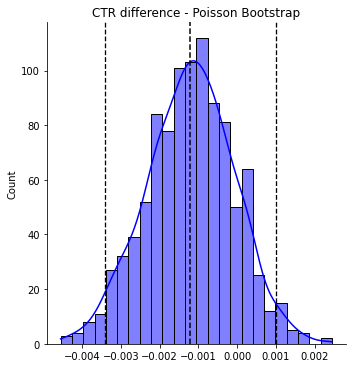

In [129]:
sns.displot(poisson_boot_res, kde=True, color='blue')
plt.title('CTR difference - Poisson Bootstrap')
plt.axvline(poisson_boot_res.mean(), ls='--', lw=1.5, c='black')
plt.axvline(quantile_l, ls='--', lw=1.3, c='black')
plt.axvline(quantile_r, ls='--', lw=1.3, c='black')
plt.show()

Доверительный интервал пересекает значение 0, следовательно, различие не является статистически значимым. Необходимо и дальше улучшать рекламное объявление для повышения конверсии.